In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

dataFrame = pd.read_csv('New_BS.csv', low_memory=False) # Remove personal information

columns = ["Device Timestamp", 'Historic Glucose mmol/L'] # Identify columns of interest

data = dataFrame.loc[0:63152, columns]

#data = dataFrame[columns] # The data of interest

                     Historic Glucose mmol/L    Month  Time (Hours)
Device Timestamp                                                   
2022-08-01 03:09:00                     27.8  2022-08      3.150000
2022-08-01 03:24:00                     27.8  2022-08      3.400000
2022-08-01 03:39:00                     27.8  2022-08      3.650000
2022-08-01 03:54:00                     27.8  2022-08      3.900000
2022-08-01 04:09:00                     27.8  2022-08      4.150000
...                                      ...      ...           ...
2022-08-30 16:49:00                     23.2  2022-08    712.816667
2022-08-30 17:04:00                     23.6  2022-08    713.066667
2022-08-30 17:19:00                     23.4  2022-08    713.316667
2022-08-30 17:34:00                     22.6  2022-08    713.566667
2022-08-30 17:49:00                     21.8  2022-08    713.816667

[1545 rows x 3 columns]


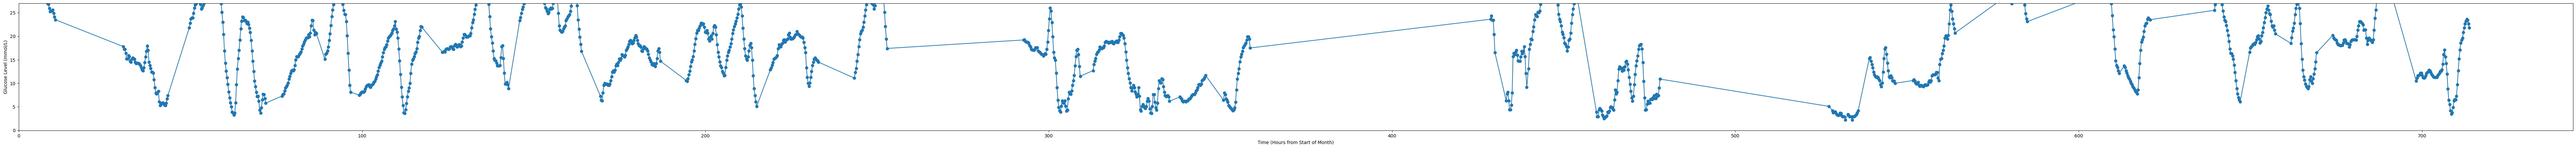

In [3]:
data['Device Timestamp'] = pd.to_datetime(data['Device Timestamp'], format="%d/%m/%Y %H:%M")
data = data.set_index('Device Timestamp')

data['Month'] = data.index.to_period('M')

data['Start of Month'] = data.index.to_period('M').to_timestamp()

data['Time (Hours)'] = (data.index - data['Start of Month']).dt.total_seconds() / 3600

data = data.drop(columns=['Start of Month'])

month_groups = data.groupby('Month')

try:
    specific_month_data = month_groups.get_group(pd.Period('2022-08'))
    print(specific_month_data)

    # Plotting
    plt.figure(figsize=(100, 5))
    plt.plot(specific_month_data['Time (Hours)'],
             specific_month_data['Historic Glucose mmol/L'],
             marker='o', linestyle='-')
    plt.xlabel("Time (Hours from Start of Month)")
    plt.ylabel("Glucose Level (mmol/L)")
    plt.xlim(0, 24 * 31)  # Assuming max days in a month for x-axis limit
    plt.ylim(0, 27)
    plt.show()
except KeyError:
    print("Data for the specified month is not available.")

<ipython-input-6-ae797e14fb01>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = specific_month_data['Historic Glucose mmol/L'].fillna(method='ffill').values


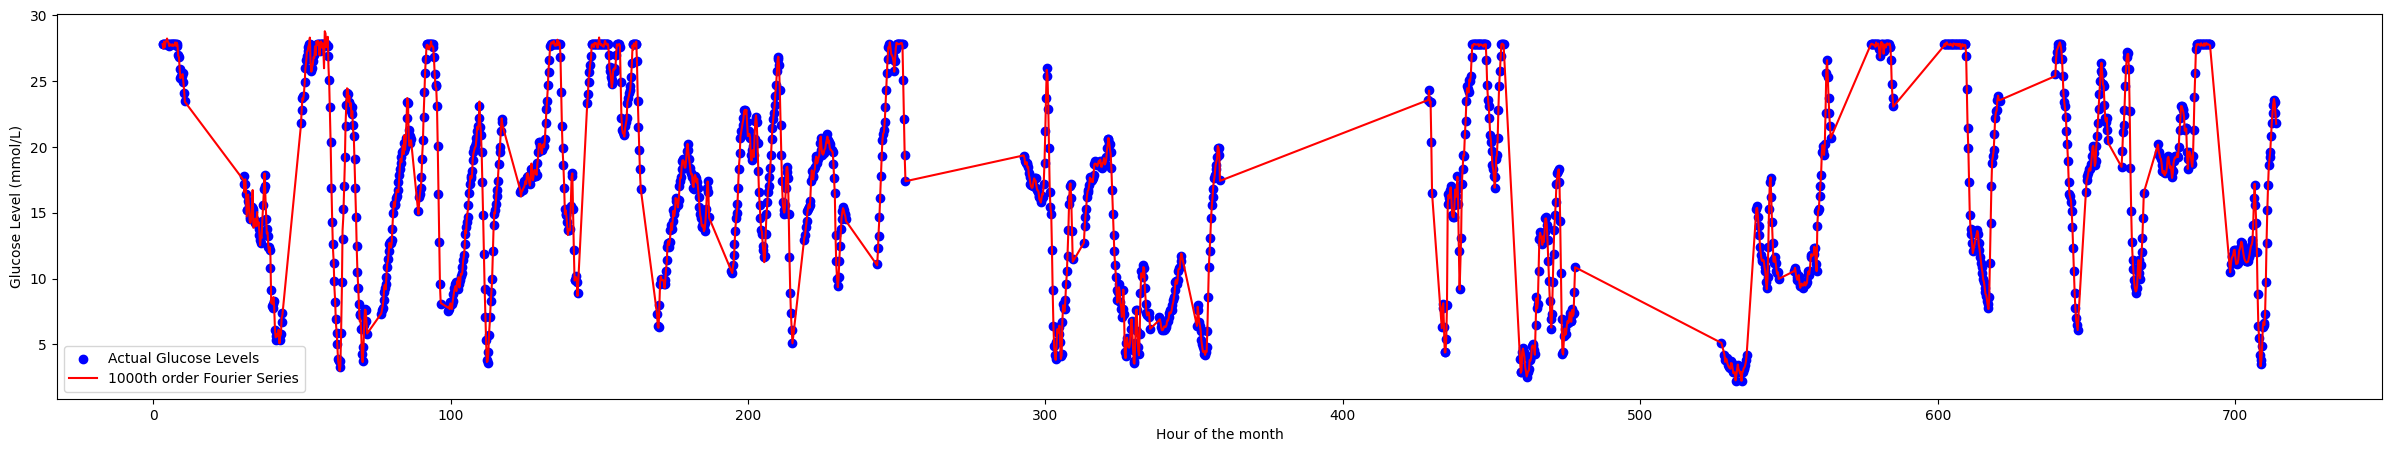

In [6]:
X = specific_month_data['Time (Hours)'].values.reshape(-1,1)
y = specific_month_data['Historic Glucose mmol/L'].fillna(method='ffill').values

def generate_fourier_features(time_data, period, num_harmonics):
    X_fourier = []
    for n in range(1, num_harmonics + 1):
        X_fourier.append(np.sin(2 * np.pi * n * time_data / period))
        X_fourier.append(np.cos(2 * np.pi * n * time_data / period))
    return np.column_stack(X_fourier)

period = 24
num_harmonics = 1000

#model fitting and parameterisation
X_fourier = generate_fourier_features(specific_month_data['Time (Hours)'], period, num_harmonics)
model = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
model.fit(X_fourier, y)
y_pred = model.predict(X_fourier)

#Interpolating data
# time_interpolated = np.arange(specific_month_data['Time (Hours)'].min(),
#                               specific_month_data['Time (Hours)'].max() + 1).reshape(-1, 1)
# X_fourier_interpolated = generate_fourier_features(time_interpolated, period, num_harmonics)
# y_pred_interpolated = model.predict(X_fourier_interpolated)

#Plotting
plt.figure(figsize=(30, 5))
plt.scatter(X, y, color='blue', label='Actual Glucose Levels')  # Plotting actual data points
plt.plot(X, y_pred, color='red', label= str(num_harmonics) + 'th order Fourier Series')  # Polynomial regression line
plt.xlabel("Hour of the month")
plt.ylabel("Glucose Level (mmol/L)")
#plt.xlim(50, 200)
#plt.ylim(0, 30)
plt.legend()
plt.show()

<ipython-input-7-aef802bba1b2>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = specific_month_data['Historic Glucose mmol/L'].fillna(method='ffill').values


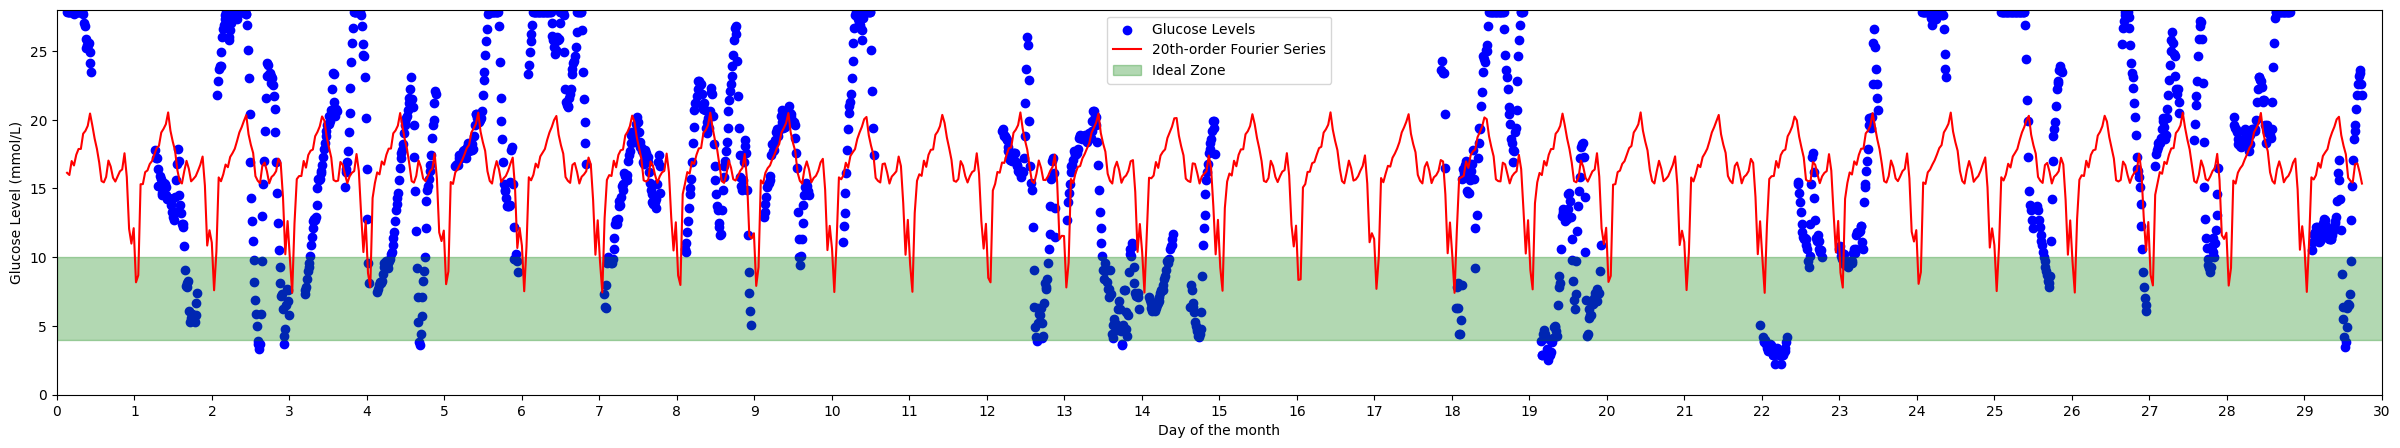

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Original data
X = specific_month_data['Time (Hours)'].values.reshape(-1,1)
y = specific_month_data['Historic Glucose mmol/L'].fillna(method='ffill').values

# Function to generate Fourier features
def generate_fourier_features(time_data, period, num_harmonics):
    X_fourier = []
    for n in range(1, num_harmonics + 1):
        X_fourier.append(np.sin(2 * np.pi * n * time_data / period))
        X_fourier.append(np.cos(2 * np.pi * n * time_data / period))
    return np.column_stack(X_fourier)

# Parameters for Fourier transformation
period = 24
num_harmonics = 20

# Generate Fourier features and fit the model
X_fourier = generate_fourier_features(specific_month_data['Time (Hours)'], period, num_harmonics)
model = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
model.fit(X_fourier, y)

# Generate interpolated time values for a smooth curve
time_interpolated = np.linspace(specific_month_data['Time (Hours)'].min(),
                                specific_month_data['Time (Hours)'].max(),
                                1000).reshape(-1, 1)  # Use 1000 points for smoothness
X_fourier_interpolated = generate_fourier_features(time_interpolated, period, num_harmonics)
y_pred_interpolated = model.predict(X_fourier_interpolated)

# Plotting
plt.figure(figsize=(30, 5))
plt.scatter(X, y, color='blue', label='Glucose Levels')  # Plotting actual data points
plt.plot(time_interpolated, y_pred_interpolated, color='red', label=f'{num_harmonics}th-order Fourier Series')  # Smooth Fourier fit
plt.xlabel("Day of the month")
plt.ylabel("Glucose Level (mmol/L)")
plt.axhspan(4, 10, xmin=0, xmax=1, color='green', alpha=0.3, label = 'Ideal Zone')
plt.xlim(0,720)
plt.ylim(0,28)
plt.legend()

tick_positions = np.arange(0, 721, 24)  # 0, 24, 48, ..., 720
tick_labels = [f'{int(hour / 24)}' for hour in tick_positions]
plt.xticks(tick_positions, tick_labels)

plt.show()


In [8]:
coefficients = model.named_steps['regressor'].coef_
scaler = model.named_steps['scaler']

# Rescale coefficients if necessary
coefficients = coefficients / scaler.scale_

# Split coefficients into sine and cosine terms
sine_coeffs = coefficients[::2]
cosine_coeffs = coefficients[1::2]

A_0 = model.named_steps['regressor'].intercept_
print("A_0 (Midpoint of the sinusoids):", A_0)

print("A =", sine_coeffs)
print("B =", cosine_coeffs)

A_0 (Midpoint of the sinusoids): 16.928220064724922
A = [ 0.83029558 -1.09434396  0.26679572 -0.49272082  0.16311491 -0.11241048
 -0.3730155  -0.22184854 -0.39871903 -0.3918356  -0.38955889 -0.09991956
 -0.15518803 -0.04062244 -0.05462016 -0.01140224  0.04437964 -0.03357848
  0.02248563 -0.0692955 ]
B = [-2.75330366e+00 -1.26507044e+00 -1.22835880e+00 -9.30150514e-01
 -6.26460130e-01  1.21698861e-02  1.26890346e-01  1.97785168e-01
  4.74931884e-01  3.00806067e-01  3.10594652e-01  2.57604229e-01
  1.30587948e-01  1.14292972e-01  8.98571710e-02  7.67885360e-04
 -2.70342118e-02 -1.04688667e-01 -1.96699134e-01 -1.03317025e-01]


(2.07452677928969, 0.24119341648872886)
[2.875773252805842, 1.6727199135743689, 1.256998531056942, 1.0525938370975778, 0.6473474878788628, 0.11306733728447657, 0.39400726197046504, 0.2972133000199401, 0.6201106014854896, 0.49398322337421946, 0.4982220090794444, 0.27630392048753194, 0.2028214430537236, 0.12129742743133036, 0.10515547091302219, 0.011428065715445777, 0.05196538505284594, 0.10994194545223823, 0.19798018347976942, 0.12440367253098895]
[0.041666666666666664, 0.08333333333333333, 0.125, 0.16666666666666666, 0.20833333333333334, 0.25, 0.2916666666666667, 0.3333333333333333, 0.375, 0.4166666666666667, 0.4583333333333333, 0.5, 0.5416666666666666, 0.5833333333333334, 0.625, 0.6666666666666666, 0.7083333333333334, 0.75, 0.7916666666666666, 0.8333333333333334]


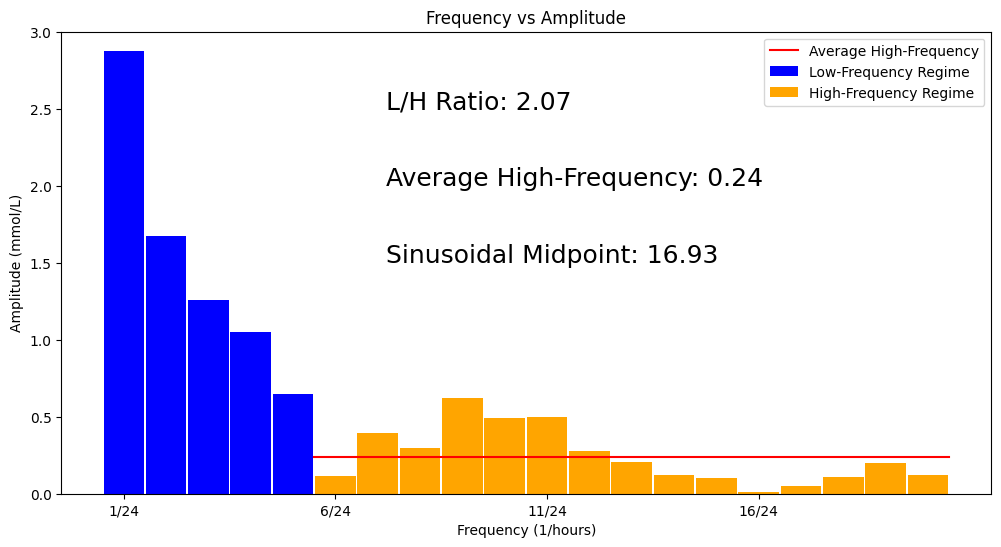

In [9]:
A_n = []
Freq = []
n = []
for i in range(0, len(sine_coeffs)):
  A_n.append(np.sqrt(sine_coeffs[i]**2+cosine_coeffs[i]**2))
  Freq.append((i+1)/24)
  n.append(i+1)

phases = np.arctan2(sine_coeffs, cosine_coeffs)

def Quant(amp, cut=5):

    l_freq_amp = amp[:cut]
    h_freq_amp = amp[cut:]

    L = np.sum(l_freq_amp)
    H = np.sum(h_freq_amp)
    L_H_Ratio = L / H if H != 0 else np.inf

    Avg_High_amp = np.mean(h_freq_amp) #Average H Freq

    return L_H_Ratio, Avg_High_amp

print(Quant(A_n, cut=5))
print(A_n)
print(Freq)

x_val = np.linspace((5.5/24),(20.5/24),20)

plt.figure(figsize=(12, 6))
plt.bar(Freq[:5], A_n[:5], width = 0.04 , color='blue', label='Low-Frequency Regime')
plt.bar(Freq[5:], A_n[5:], width = 0.04 ,color='orange', label='High-Frequency Regime')
plt.plot(x_val, Quant(A_n, cut=5)[1]*(x_val/x_val), color = 'red', label='Average High-Frequency')
plt.text(0.3, 2.5, f'L/H Ratio: {round(Quant(A_n, cut=5)[0], 2)}', fontsize=18)
plt.text(0.3, 2, f'Average High-Frequency: {round(Quant(A_n, cut=5)[1], 2)}', fontsize=18)
plt.text(0.3, 1.5, f'Sinusoidal Midpoint: {round(A_0 , 2)}', fontsize=18)
tick_positions = [1/24, 6/24, 11/24, 16/24]
tick_labels = ["1/24", "6/24", "11/24", "16/24"]
plt.xticks(tick_positions, tick_labels)
plt.xlabel('Frequency (1/hours)')
plt.ylabel('Amplitude (mmol/L)')
plt.ylim(0,3)
plt.title('Frequency vs Amplitude')
plt.legend()
plt.show()